In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import re 
from pathlib import Path
import tarfile 
import urllib.request
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


In [2]:
def download_titanic_dataset():
    tarball_path = Path("datasets/titanic.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://homl.info/titanic.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as titanic_tarball:
            titanic_tarball.extractall(path="datasets")

def read_dataset(dataset_type):
    return pd.read_csv(f'datasets/titanic/{dataset_type}.csv')

def categorical_count(data, cat_col):
    sns.countplot(x=data[cat_col])
    plt.show()
    
    cat_col_count = data[cat_col].value_counts().to_frame(name='count').reset_index()
    cat_col_count['percent'] = round((cat_col_count['count'] / cat_col_count['count'].sum()) * 100,2)
    cat_col_count.sort_values(cat_col)
    return cat_col_count

def feature_survival(data, col):
    data_count = data.groupby([col, 'survived']).count()['passengerid'].to_frame(name='count').reset_index()
    data_count['percent'] = round((data_count['count'] / data_count['count'].sum()) * 100,2)
    sns.barplot(x=data_count[col], y=data_count['percent'], hue=data_count['survived'])
    plt.show()
    return data_count

## Data preprocessing functions
# Custom transformer to cast to int and retain feature names
class AgeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.astype(int)
    
    def get_feature_names_out(self, input_features=None):
        return input_features

def age_pipeline():
    return make_pipeline(SimpleImputer(strategy='mean'), AgeTransformer(), StandardScaler())

def embarked_pipeline():
    return make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='if_binary'))

def add_travellers(data):
    return np.sum(data, axis=1).to_numpy().reshape(-1, 1)

def traveller_name(function_transformer, feature_names_in):
    return ["group_size"]

# Correct the group_travel_pipeline
def group_travel_pipeline():
    return make_pipeline(FunctionTransformer(add_travellers, feature_names_out=traveller_name), StandardScaler())

##### Ingest and Inspect Data Types/Statistics

In [3]:
# download titanic dataset
download_titanic_dataset()

# read train and test datasets into dataframe
train_df = read_dataset('train')
test_df = read_dataset('test')

# create copy of training dataset 
titanic = train_df.copy()

In [4]:
# lower case column names
titanic.columns = titanic.columns.str.lower()

# inspect first 5 rows
titanic.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# print train dataset info 
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# missing value percentage
missing_cols = ['age', 'cabin', 'embarked']

for col in missing_cols:
    print(f"{col}: {round(titanic[col].isna().sum() / len(titanic) * 100, 2)} %")

age: 19.87 %
cabin: 77.1 %
embarked: 0.22 %


In [7]:
# summary statistics on titanic dataset
titanic.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Exploratory Data Analysis

#### A. Univariate Analysis - Categorical Data

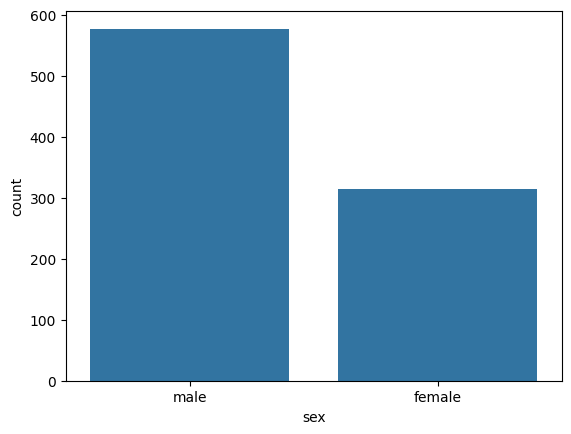

,sex,count,percent
0,male,577,64.76
1,female,314,35.24


In [8]:
categorical_count(titanic, 'sex')

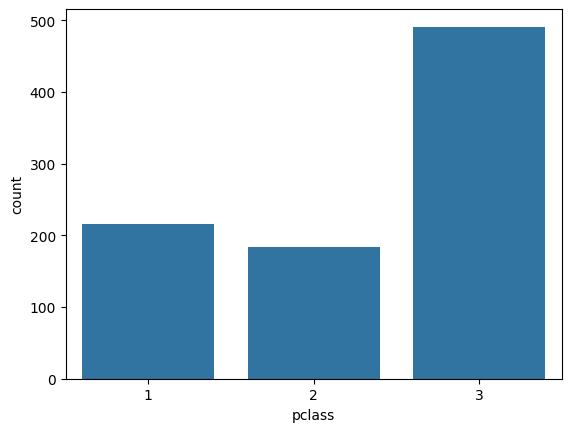

,pclass,count,percent
0,3,491,55.11
1,1,216,24.24
2,2,184,20.65


In [9]:
categorical_count(titanic, 'pclass')

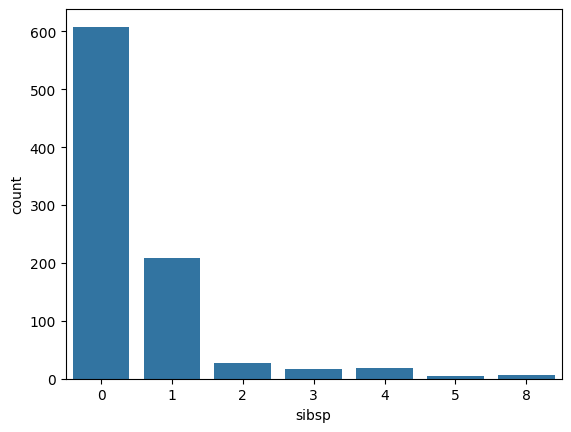

,sibsp,count,percent
0,0,608,68.24
1,1,209,23.46
2,2,28,3.14
3,4,18,2.02
4,3,16,1.80
5,8,7,0.79
6,5,5,0.56


In [10]:
categorical_count(titanic, 'sibsp')

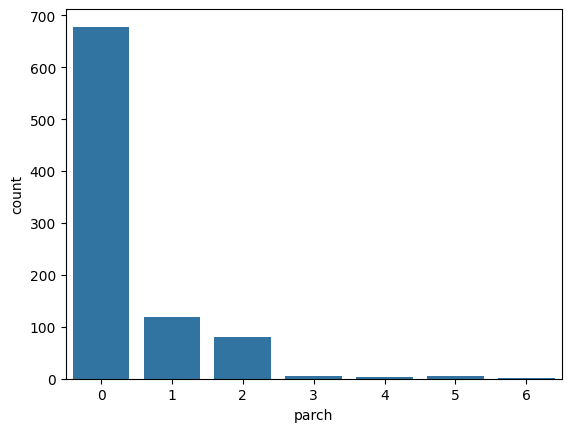

,parch,count,percent
0,0,678,76.09
1,1,118,13.24
2,2,80,8.98
3,5,5,0.56
4,3,5,0.56
5,4,4,0.45
6,6,1,0.11


In [11]:
categorical_count(titanic, 'parch')

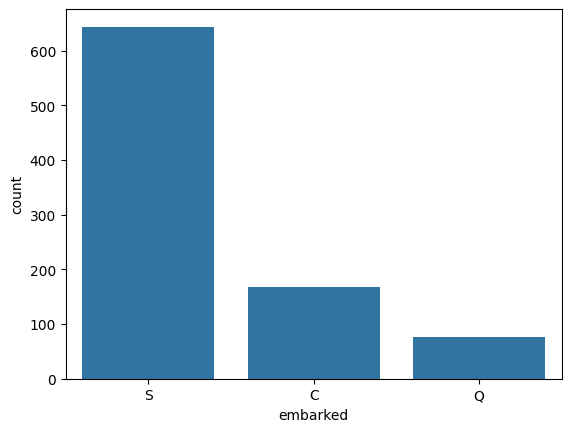

,embarked,count,percent
0,S,644,72.44
1,C,168,18.90
2,Q,77,8.66


In [12]:
categorical_count(titanic, 'embarked')

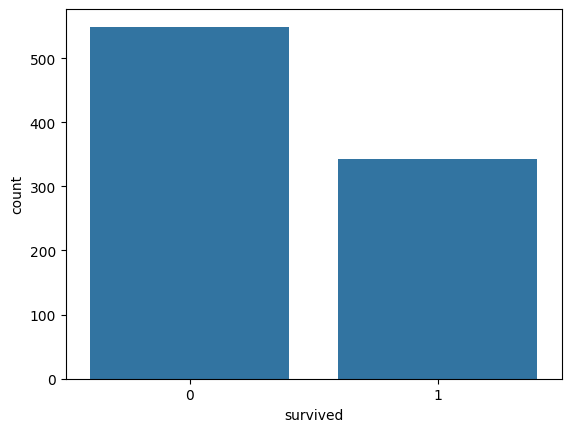

,survived,count,percent
0,0,549,61.62
1,1,342,38.38


In [13]:
categorical_count(titanic, 'survived')

#### B. Univariate Analysis - Numerical Data

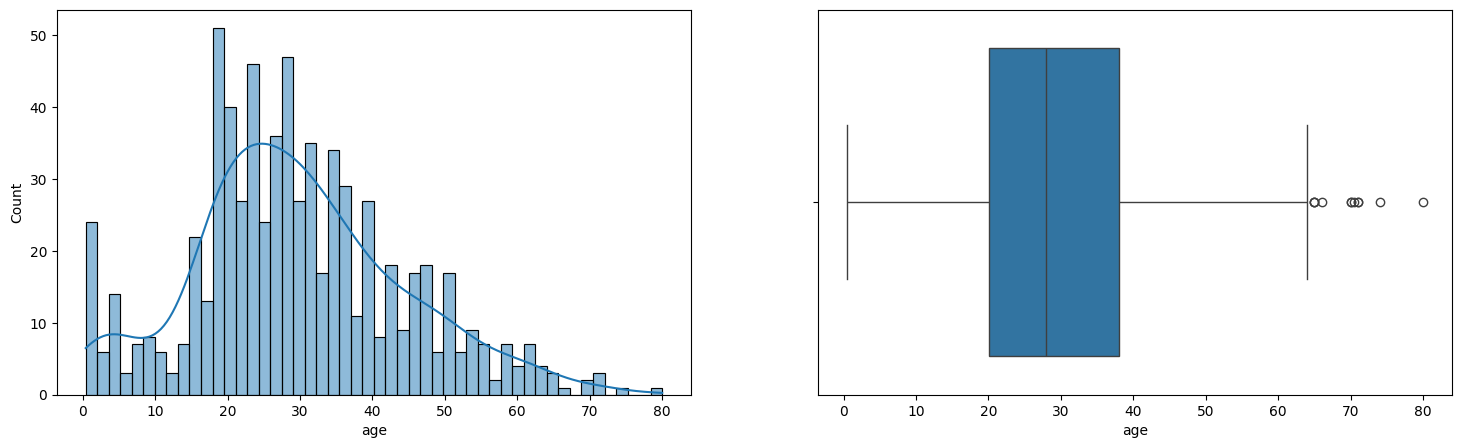

In [14]:
# Age Distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

for i, col in enumerate(titanic.columns):
    if col == 'age':
        sns.histplot(titanic[col], bins=50, kde=True, ax=axes[0])
        sns.boxplot(x=titanic[col])

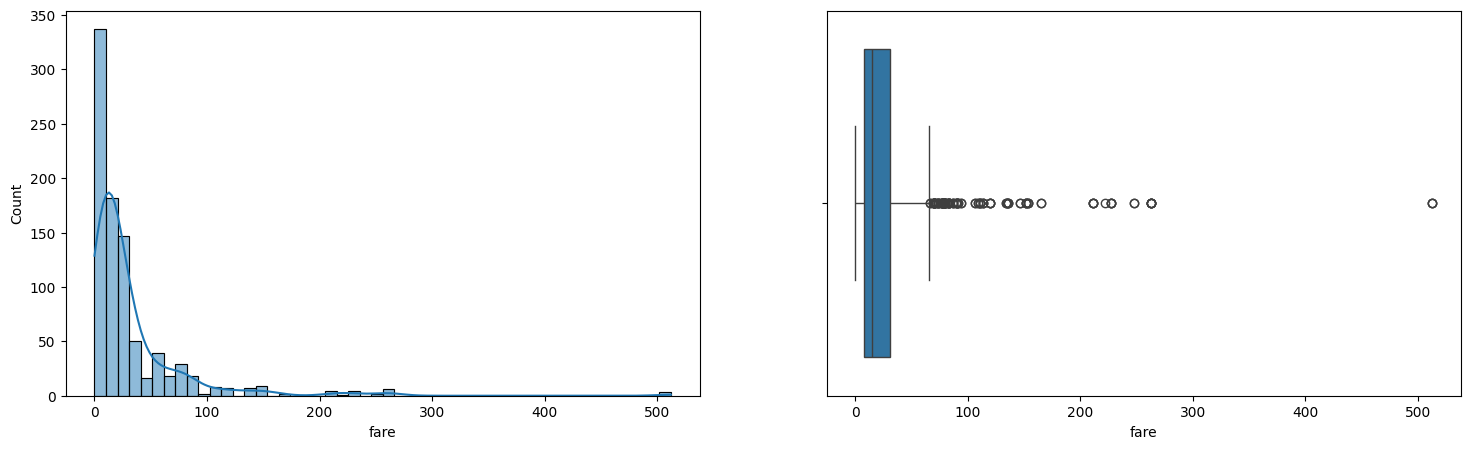

In [15]:
# Age Distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,5))

for i, col in enumerate(titanic.columns):
    if col == 'fare':
        sns.histplot(titanic[col], bins=50, kde=True, ax=axes[0])
        sns.boxplot(x=titanic[col])

#### C. Multivariate Analysis

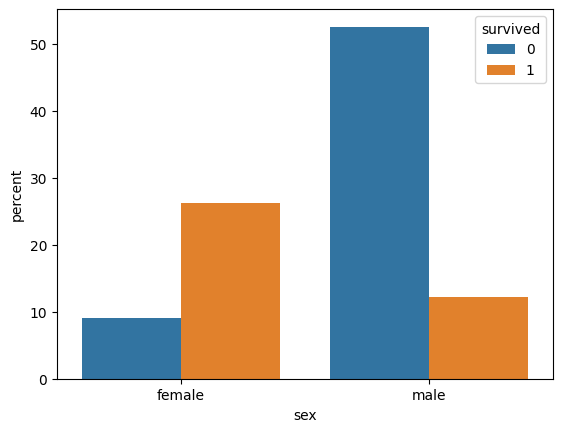

In [16]:
## Plot features against target variable
sex_survival = feature_survival(titanic, 'sex')

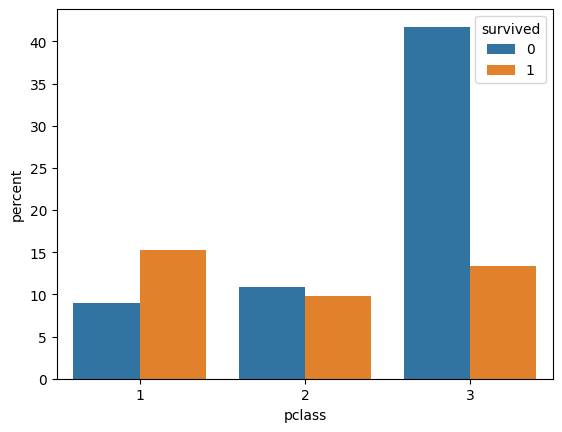

In [17]:
pclass_survival = feature_survival(titanic, 'pclass')

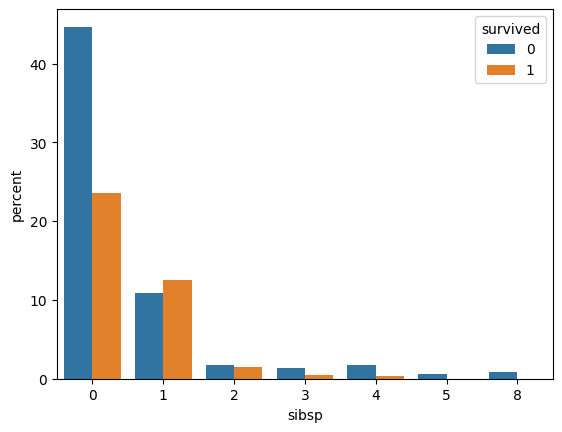

In [18]:
sibsp_survival = feature_survival(titanic, 'sibsp')

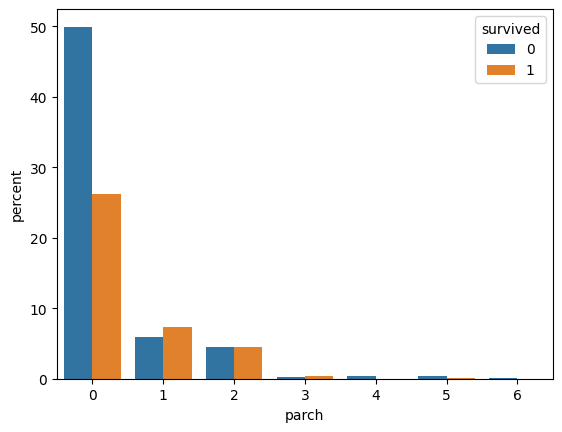

In [19]:
parch_survival = feature_survival(titanic, 'parch')

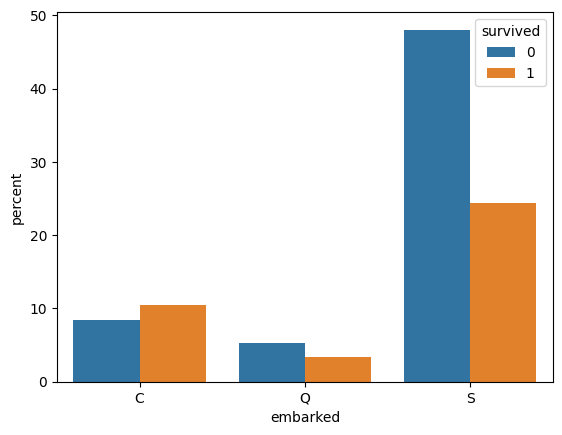

In [20]:
embarked_survival = feature_survival(titanic, 'embarked')

<Axes: >

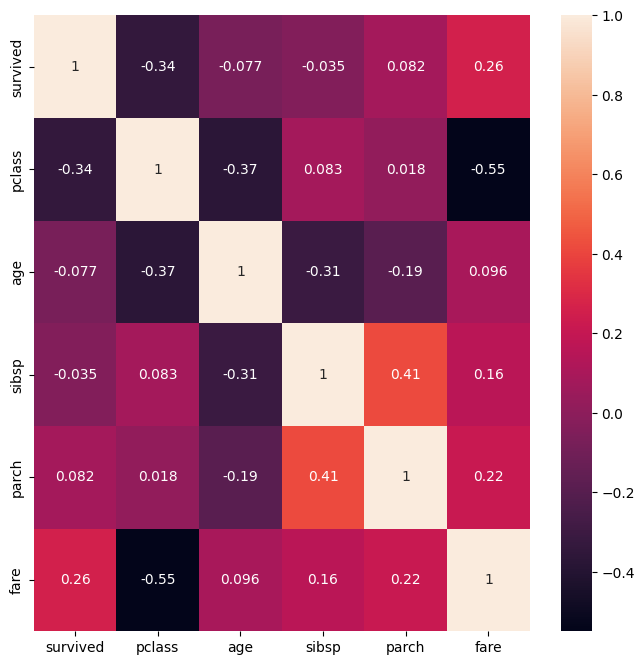

In [21]:
plt.figure(figsize=(8,8))
sns.heatmap(titanic.drop(columns=['name', 'sex', 'ticket', 'cabin', 'passengerid', 'embarked']).corr(), annot=True)


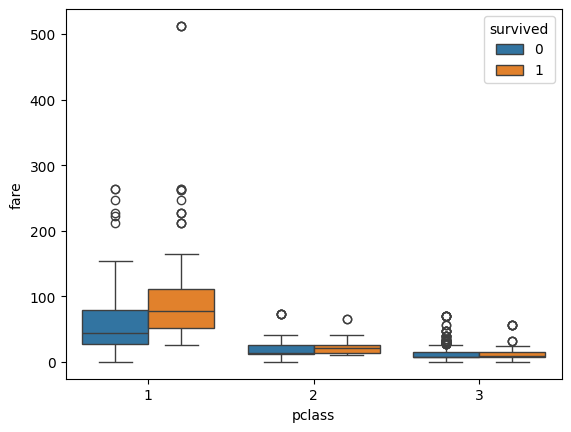

In [22]:
# Exploring fare and pclass relationship
sns.boxplot(x=titanic['pclass'], y=titanic['fare'], hue=titanic['survived'])
plt.show()

In [23]:
# extract title from name
titanic['title'] = titanic.name.str.split('.', expand=True)[0].str.split(',',expand=True)[1].str.replace(' ', '')
titanic['title'] = titanic.title.str.replace('Mme', 'Mrs')
titanic['title'] = titanic.title.str.replace('Mlle', 'Miss')
titanic['title'] = titanic.title.str.replace('Ms', 'Miss')
titanic['title'] = np.where((titanic['title'] == 'Jonkheer') | 
                                (titanic['title'] == 'theCountess') | 
                                    (titanic['title'] == 'Col') | 
                                        (titanic['title'] == 'Capt') | 
                                            (titanic['title'] == 'Don') | 
                                                (titanic['title'] == 'Dr') | 
                                                    (titanic['title'] == 'Master') | 
                                                        (titanic['title'] == 'Rev') | 
                                                            (titanic['title'] == 'Major') | 
                                                                (titanic['title'] == 'Sir') | 
                                                                    (titanic['title'] == 'Lady'), 'Other', titanic['title'])

In [24]:
# drop passenger id and cabin columns
clean_titanic = titanic.drop(columns=['passengerid', 'cabin', 'ticket', 'name'])

#### Data Preprocessing

In [25]:
# Create the ColumnTransformer
test_preprocessing = ColumnTransformer(
    [
        ("age", age_pipeline(), ["age"]),  # Removed the parentheses
        ("embarked", embarked_pipeline(), ["embarked"]),  # Removed the parentheses
        ("pclass", OrdinalEncoder(), ["pclass"]), 
        ("fare", StandardScaler(), ["fare"]),
        ("sex", OneHotEncoder(drop='if_binary'), ["sex"]), 
        ("title", OneHotEncoder(), ["title"]), 
        ("group_travel", group_travel_pipeline(), ["sibsp", "parch"])
    ],
    remainder='drop', verbose_feature_names_out=False
)

In [26]:
# Custom transformer for final processing in the pipeline
class FinaliseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, test_preprocessing):
        self.test_preprocessing = test_preprocessing

    def fit(self, X, y=None):
        # Fit the preprocessing pipeline on the data
        self.test_preprocessing.fit(X, y)
        return self

    def transform(self, X):
        # Apply the transformations
        transformed_data = self.test_preprocessing.transform(X)
        
        # Get the feature names after transformation
        feature_names = self.test_preprocessing.get_feature_names_out()
        
        # Convert to DataFrame and assign feature names
        transformed_df = pd.DataFrame(transformed_data, columns=feature_names)
        
        return transformed_df

In [27]:
final_train = FinaliseTransformer(test_preprocessing).fit_transform(clean_titanic)

In [28]:
final_train.head()

,age,embarked_C,embarked_Q,embarked_S,pclass,fare,sex_male,title_Miss,title_Mr,title_Mrs,title_Other,group_size
0,-0.580044,0.0,0.0,1.0,2.0,-0.502445,1.0,0.0,1.0,0.0,0.0,0.059160
1,0.650112,1.0,0.0,0.0,0.0,0.786845,0.0,0.0,0.0,1.0,0.0,0.059160
2,-0.272505,0.0,0.0,1.0,2.0,-0.488854,0.0,1.0,0.0,0.0,0.0,-0.560975
3,0.419458,0.0,0.0,1.0,0.0,0.420730,0.0,0.0,0.0,1.0,0.0,0.059160
4,0.419458,0.0,0.0,1.0,2.0,-0.486337,1.0,0.0,1.0,0.0,0.0,-0.560975


#### Model Selection

##### A. Logistic Regression

In [29]:
# # Logistic Regression is assumed to be the baseline
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score, cross_val_predict

# ## assign feature and target variables
X_train = final_train
y_train = titanic[['survived']]

In [30]:
# # Conduct Grid Search
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("finalise", FinaliseTransformer(test_preprocessing)), 
    ("regression", LogisticRegression(random_state=42))
])

# Define the parameter grid
params_grid = [
    {'regression__penalty' : ['l1', 'l2'],
     'regression__solver' : ['liblinear'],  # liblinear works with l1 and l2
     'regression__C' : [0.1, 1, 10]
    },
    {'regression__penalty' : ['l2', 'none'],
     'regression__solver' : ['newton-cg', 'lbfgs'],  # these solvers work with l2 and none
     'regression__C' : [0.1, 1, 10]
    },
    {'regression__penalty' : ['elasticnet'],
     'regression__solver' : ['saga'],  # saga is needed for elasticnet
     'regression__C' : [0.1, 1, 10],
     'regression__l1_ratio': [0.5]  # l1_ratio must be specified for elasticnet
    }
]

# Conduct Grid Search
lr_gridsearch = GridSearchCV(full_pipeline, params_grid, cv=5, scoring="recall")
lr_gridsearch.fit(X_train, y_train)


ValueError: 
All the 105 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
105 fits failed with the following error:
Traceback (most recent call last):
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'embarked'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 361, in _get_column_indices
    col_idx = all_columns.get_loc(col)
              ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    raise KeyError(key) from err
KeyError: 'embarked'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/joblib/memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_1724/3623281708.py", line 8, in fit
    self.test_preprocessing.fit(X, y)
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 922, in fit
    self.fit_transform(X, y=y, **params)
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/utils/_set_output.py", line 313, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 968, in fit_transform
    self._validate_column_callables(X)
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py", line 536, in _validate_column_callables
    transformer_to_input_indices[name] = _get_column_indices(X, columns)
                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspaces/machine-learning/.venv/lib/python3.12/site-packages/sklearn/utils/_indexing.py", line 369, in _get_column_indices
    raise ValueError("A given column is not a column of the dataframe") from e
ValueError: A given column is not a column of the dataframe
